In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
from hmpai.pytorch.training import train, validate, calculate_class_weights, train_and_test, k_fold_cross_validate, test
from hmpai.pytorch.utilities import DEVICE, set_global_seed, get_summary_str, save_model, load_model
from hmpai.pytorch.generators import SAT1Dataset

from hmpai.data import SAT1_STAGES_ACCURACY, SAT_CLASSES_ACCURACY
from hmpai.visualization import plot_confusion_matrix, get_padded_slices, plot_predictions_on_epoch, plot_stage_predictions
from hmpai.normalization import *
from torch.utils.data import DataLoader

from torchvision.transforms import Compose
from hmpai.pytorch.transforms import *
from hmpai.behaviour.sat2 import read_behavioural_info
import matplotlib.pyplot as plt

import seaborn as sns
import netCDF4
import xarray as xr
import os
from pathlib import Path
from hmpai.pytorch.models import *
from hmpai.training import split_data_on_participants
import pandas as pd

In [2]:
DATA_PATH = Path(os.getenv("DATA_PATH"))
data_path = DATA_PATH / "sat2/split_stage_data_100hz.nc"
dataset = xr.load_dataset(data_path)

In [3]:
dataset

<xarray.Dataset> Size: 5GB
Dimensions:      (channels: 30, samples: 100, epochs: 2446, participant: 18,
                  labels: 5)
Coordinates:
  * channels     (channels) <U3 360B 'Fp1' 'Fp2' 'AFz' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 800B 0 1 2 3 4 5 6 7 ... 93 94 95 96 97 98 99
  * epochs       (epochs) int64 20kB 0 1 2 3 4 5 ... 2442 2443 2444 2445 2446
  * participant  (participant) <U3 216B 'S1' 'S10' 'S11' ... 'S7' 'S8' 'S9'
  * labels       (labels) <U13 260B 'confirmation' 'decision' ... 'response'
    event_name   (participant, epochs) <U21 4MB '' 'low/speed/right/1' ... ''
    rt           (participant, epochs) float64 352kB nan 0.4092 ... 1.319 nan
Data variables:
    data         (participant, epochs, labels, channels, samples) float64 5GB ...

In [3]:
# Accuracy (training)
indexer = (dataset.cue == 'AC' if 'sat1' in str(data_path) else dataset.event_name.str.contains("accuracy"))
dataset_acc = dataset.where(indexer, drop=True)
# del dataset

In [4]:
# Speed (inference)
indexer = (dataset.cue == 'SP' if 'sat1' in str(data_path) else dataset.event_name.str.contains("speed"))
dataset_sp = dataset.where(indexer, drop=True)
del dataset

In [5]:
shape_topological = False
info_to_keep = ['rt', 'participant', 'epochs']
set_global_seed(42)
train_data, val_data, test_data = split_data_on_participants(
    dataset_acc, 60, norm_min1_to_1
)

transform = Compose([ChannelsDropout(probability=0.5, p_drop=0.4)])
# transform = Compose([ChannelsDropout(probability=0.5, p_drop=0.4)])
# transform = Compose([GaussianNoise(0.5, 0.16)])
# transform = Compose([ChannelsDropout(0.5, 0.4), TimeReverse(0.5)])
# transform = Compose([ChannelsDropout(0.33, 0.4), TimeReverse(0.33), GaussianNoise(0.33, 0.16)])
# del dataset_acc
train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, transform=transform)
# train_dataset = SAT1Dataset(train_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# del train_data
val_dataset = SAT1Dataset(val_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY)
# del val_data
test_dataset = SAT1Dataset(test_data, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, info_to_keep=info_to_keep)
# del test_data

['S12', 'S1', 'S18', 'S9', 'S6', 'S11', 'S3', 'S10']


In [6]:
set_global_seed(42)
_, _, test_data_sp = split_data_on_participants(
    dataset_sp, 60, norm_min1_to_1
)
test_dataset_sp = SAT1Dataset(test_data_sp, shape_topological=shape_topological, labels=SAT_CLASSES_ACCURACY, info_to_keep=info_to_keep)


['S12', 'S1', 'S18', 'S9', 'S6', 'S11', 'S3', 'S10']


### Training

In [13]:
model = SAT1GRU(30, 0, 5)
torch.set_grad_enabled(True)
train_and_test(
    model,
    train_dataset,
    [test_dataset, test_dataset_sp],
    test_dataset_sp, # Validate using speed to see metric progression over training
    # val_dataset, # val_dataset
    logs_path=Path("../logs/"),
    epochs=20,
    workers=0,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    weight_decay=0.001,
    label_smoothing=0.001,
    # lr=0.001,
    do_spectral_decoupling=False,
)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.41      0.99      0.58      4011
           1       0.70      0.63      0.66      4362
           2       0.69      0.30      0.42      4362
           3       0.00      0.00      0.00         0
           4       0.47      0.14      0.22      4362

    accuracy                           0.51     17097
   macro avg       0.45      0.41      0.38     17097
weighted avg       0.57      0.51      0.47     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.54      0.99      0.70      4011
           1       0.90      0.61      0.72      4362
           2       0.89      0.91      0.90      4362
           3       0.00      0.00      0.00         0
           4       0.59      0.21      0.31      4362

    accuracy                           0.67     17097
   macro avg       0.58      0.54      0.53     17097
weighted avg       0.73      0.67      0.66     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.84      0.92      0.88      4011
           1       0.78      0.65      0.71      4362
           2       0.90      0.51      0.65      4362
           3       0.00      0.00      0.00         0
           4       0.80      0.87      0.83      4362

    accuracy                           0.73     17097
   macro avg       0.66      0.59      0.61     17097
weighted avg       0.83      0.73      0.76     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.69      0.95      0.80      4011
           1       0.83      0.74      0.79      4362
           2       0.99      0.03      0.06      4362
           3       0.00      0.00      0.00         0
           4       0.76      0.56      0.65      4362

    accuracy                           0.56     17097
   macro avg       0.66      0.46      0.46     17097
weighted avg       0.82      0.56      0.57     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.59      0.96      0.73      4011
           1       0.80      0.78      0.79      4362
           2       0.92      0.70      0.80      4362
           3       0.00      0.00      0.00         0
           4       0.75      0.42      0.54      4362

    accuracy                           0.71     17097
   macro avg       0.61      0.57      0.57     17097
weighted avg       0.77      0.71      0.71     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4011
           1       0.85      0.70      0.77      4362
           2       1.00      0.28      0.44      4362
           3       0.00      0.00      0.00         0
           4       0.81      0.88      0.85      4362

    accuracy                           0.69     17097
   macro avg       0.72      0.56      0.60     17097
weighted avg       0.90      0.69      0.74     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4011
           1       0.83      0.78      0.80      4362
           2       0.98      0.30      0.46      4362
           3       0.00      0.00      0.00         0
           4       0.83      0.90      0.86      4362

    accuracy                           0.72     17097
   macro avg       0.72      0.58      0.61     17097
weighted avg       0.90      0.72      0.76     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4011
           1       0.76      0.82      0.79      4362
           2       0.89      0.90      0.90      4362
           3       0.00      0.00      0.00         0
           4       0.90      0.77      0.83      4362

    accuracy                           0.85     17097
   macro avg       0.70      0.68      0.69     17097
weighted avg       0.88      0.85      0.86     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.91      0.93      0.92      4011
           1       0.74      0.85      0.79      4362
           2       0.90      0.91      0.90      4362
           3       0.00      0.00      0.00         0
           4       0.90      0.70      0.79      4362

    accuracy                           0.85     17097
   macro avg       0.69      0.68      0.68     17097
weighted avg       0.86      0.85      0.85     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      4011
           1       0.78      0.85      0.81      4362
           2       0.92      0.88      0.90      4362
           3       0.00      0.00      0.00         0
           4       0.88      0.74      0.81      4362

    accuracy                           0.85     17097
   macro avg       0.69      0.68      0.68     17097
weighted avg       0.87      0.85      0.85     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      4011
           1       0.73      0.84      0.78      4362
           2       0.90      0.87      0.88      4362
           3       0.00      0.00      0.00         0
           4       0.88      0.70      0.78      4362

    accuracy                           0.83     17097
   macro avg       0.68      0.67      0.67     17097
weighted avg       0.85      0.83      0.84     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      4011
           1       0.65      0.87      0.75      4362
           2       0.94      0.85      0.89      4362
           3       0.00      0.00      0.00         0
           4       0.90      0.54      0.68      4362

    accuracy                           0.80     17097
   macro avg       0.67      0.64      0.64     17097
weighted avg       0.84      0.80      0.80     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.77      0.94      0.85      4011
           1       0.69      0.91      0.79      4362
           2       0.95      0.73      0.83      4362
           3       0.00      0.00      0.00         0
           4       0.85      0.59      0.69      4362

    accuracy                           0.79     17097
   macro avg       0.65      0.63      0.63     17097
weighted avg       0.82      0.79      0.79     17097



[{'0.0': {'precision': 0.9724933451641526,
   'recall': 0.877502001601281,
   'f1-score': 0.9225589225589226,
   'support': 3747.0},
  '1.0': {'precision': 0.8147953830010494,
   'recall': 0.763895720609936,
   'f1-score': 0.7885250063467886,
   'support': 4066.0},
  '2.0': {'precision': 0.960319901568748,
   'recall': 0.7678307919331038,
   'f1-score': 0.8533552002186688,
   'support': 4066.0},
  '3.0': {'precision': 0.7412228796844181,
   'recall': 0.9242498770290212,
   'f1-score': 0.8226795096322241,
   'support': 4066.0},
  '4.0': {'precision': 0.8556815654881031,
   'recall': 0.9463846532218396,
   'f1-score': 0.8987504379306318,
   'support': 4066.0},
  'accuracy': 0.8556294038278947,
  'macro avg': {'precision': 0.8689026149812943,
   'recall': 0.8559726088790363,
   'f1-score': 0.8571738153374472,
   'support': 20011.0},
  'weighted avg': {'precision': 0.8672512510850205,
   'recall': 0.8556294038278947,
   'f1-score': 0.8561314961528163,
   'support': 20011.0}},
 {'0.0': {'pr

In [12]:
model = MambaModel(embed_dim=128, n_channels=30, n_classes=5, n_layers=4, global_pool=True, dropout=0.0)
# model = SAT1GRU(n_channels=30, n_samples=100, n_classes=5)
torch.set_grad_enabled(True)

train_and_test(
    model,
    train_dataset,
    [test_dataset, test_dataset_sp],
    test_dataset_sp, # Validate using speed to see metric progression over training
    # val_dataset, # val_dataset
    logs_path=Path("../logs/"),
    epochs=20,
    workers=0,
    batch_size=128,
    labels=SAT_CLASSES_ACCURACY,
    weight_decay=0.01,
    label_smoothing=0.1,
    lr=0.0001,
    do_spectral_decoupling=False,
)

  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.26      1.00      0.42      4011
           1       0.00      0.00      0.00      4362
           2       1.00      0.00      0.00      4362
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00      4362

    accuracy                           0.23     17097
   macro avg       0.25      0.20      0.08     17097
weighted avg       0.32      0.23      0.10     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

              precision    recall  f1-score   support

           0       0.28      1.00      0.44      4011
           1       0.14      0.00      0.00      4362
           2       1.00      0.00      0.00      4362
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00      4362

    accuracy                           0.24     17097
   macro avg       0.28      0.20      0.09     17097
weighted avg       0.36      0.24      0.10     17097



  0%|          | 0/376 [00:00<?, ? batch/s]

KeyboardInterrupt: 

### Examining

In [14]:
test_loader = DataLoader(
    test_dataset_sp, 128, shuffle=True, num_workers=0, pin_memory=True
)
results, pred, true = test(model, test_loader, None, class_labels=SAT_CLASSES_ACCURACY)
pred = pred.cpu()

0.8478095572322629


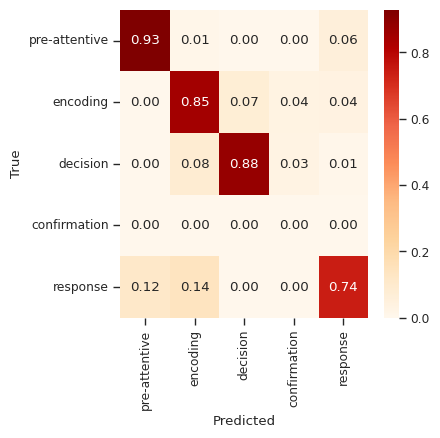

In [15]:
plot_confusion_matrix(true, pred, SAT_CLASSES_ACCURACY)

In [7]:
# Load model
chk_path = Path("../models/sat2_mamba_gen.pt")
checkpoint = load_model(chk_path)

model_kwargs = {
    "embed_dim": 256,
    "n_channels": 30,
    "n_classes": 5,
    "n_layers": 6,
    "global_pool": True,
}
model = MambaModel(**model_kwargs)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(DEVICE)

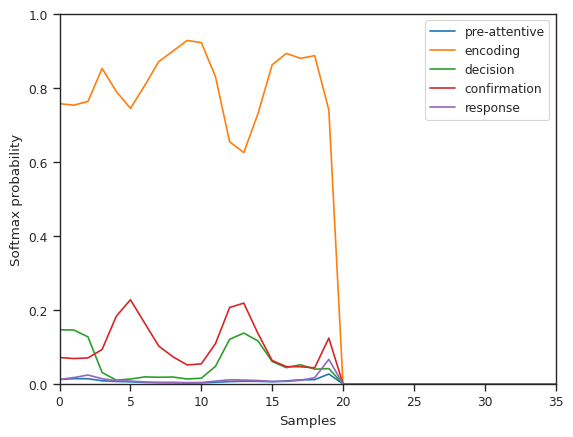

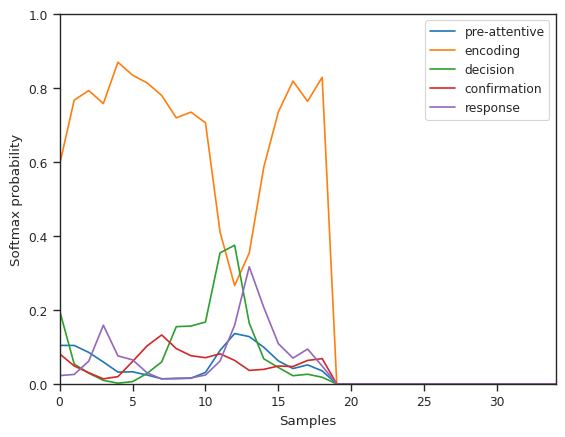

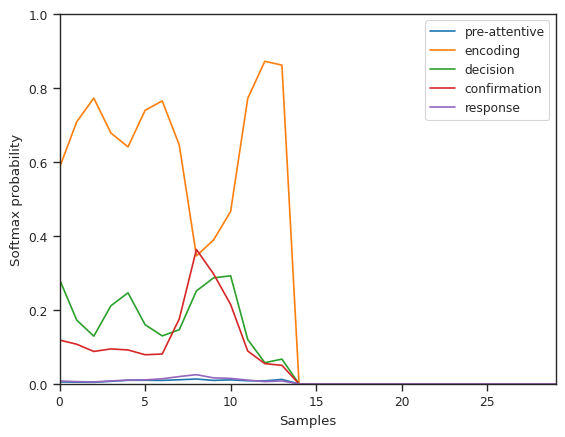

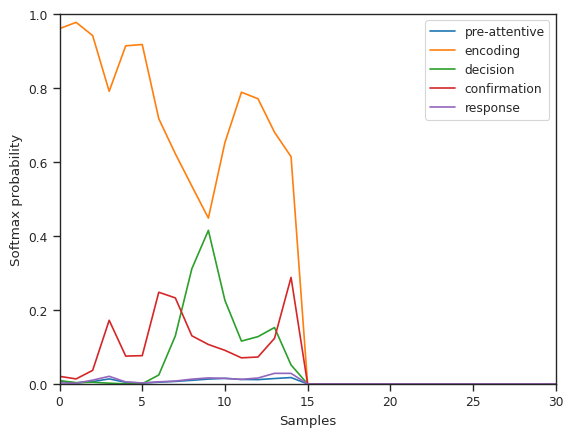

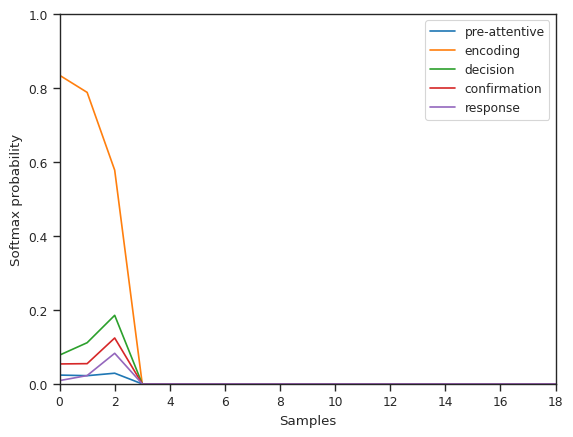

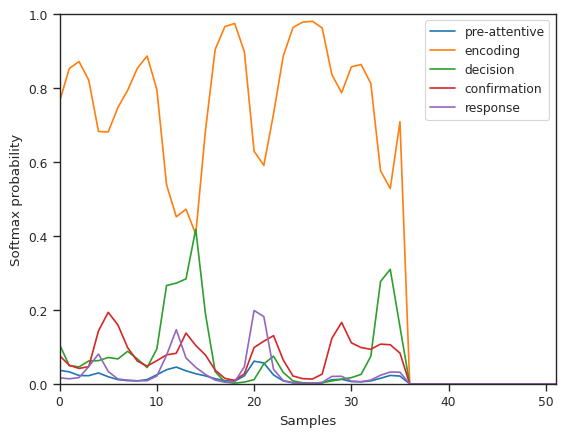

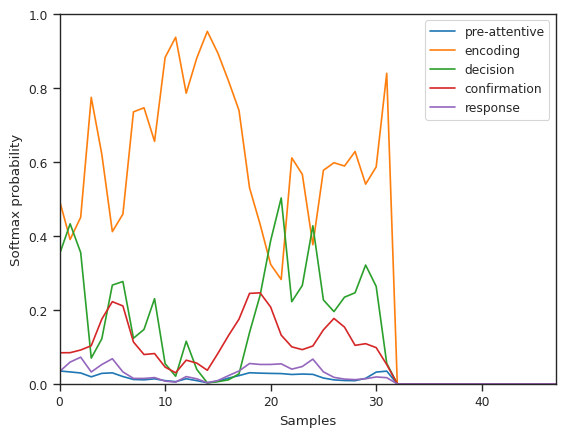

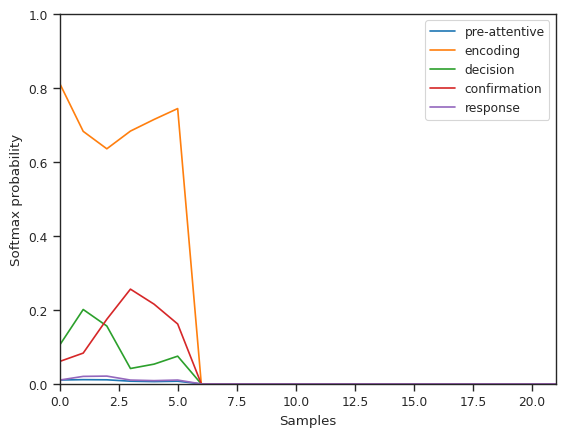

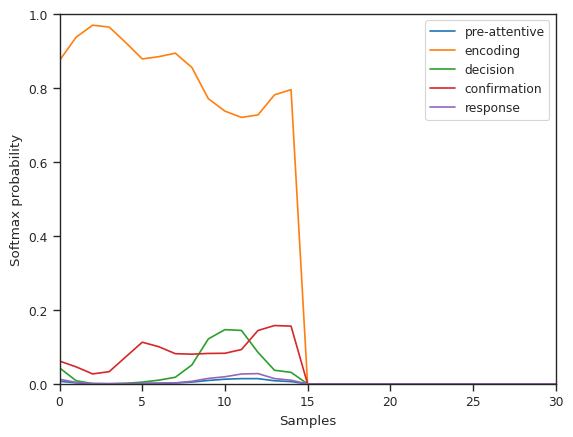

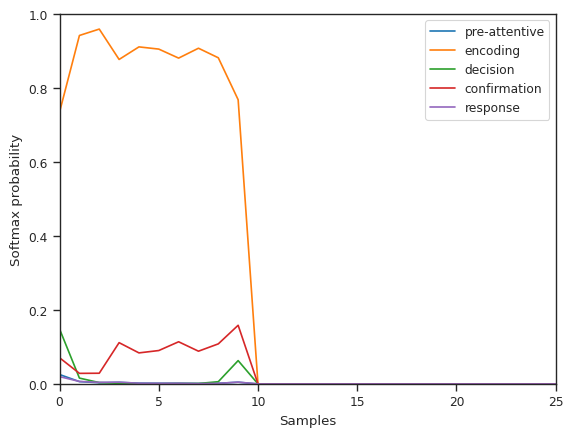

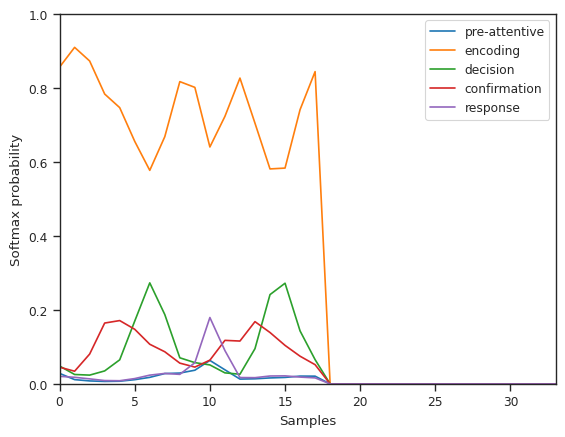

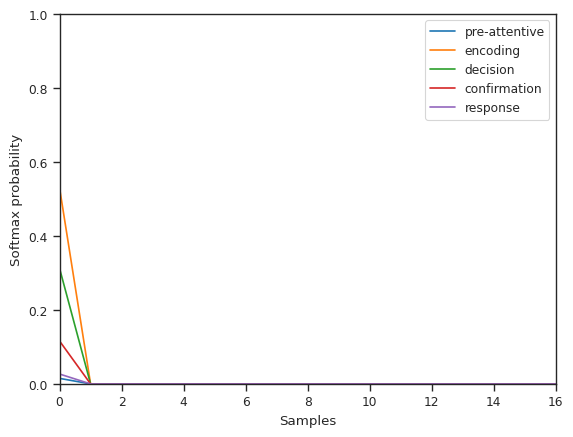

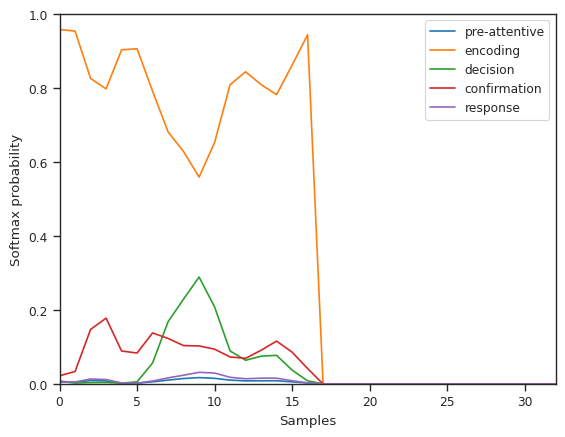

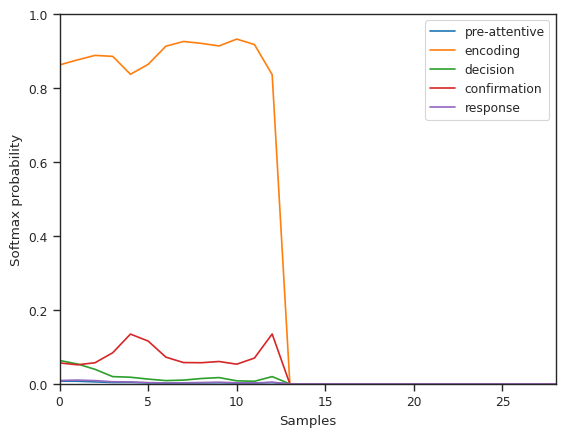

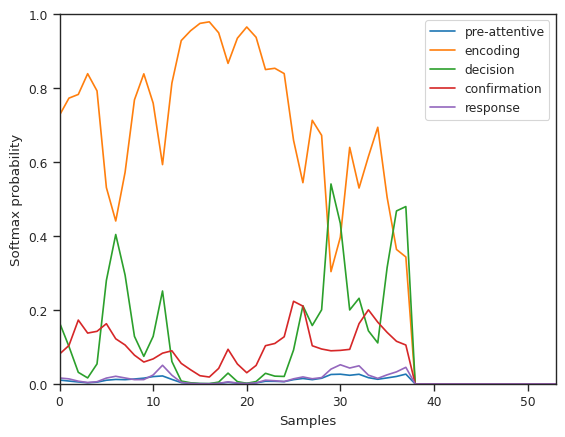

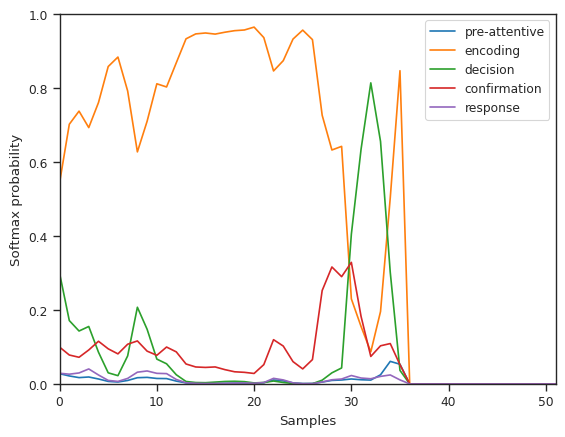

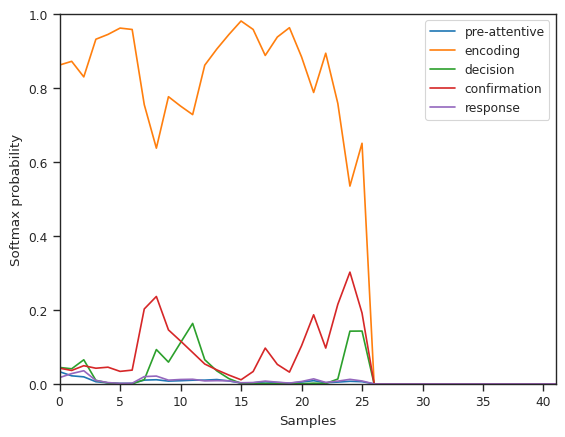

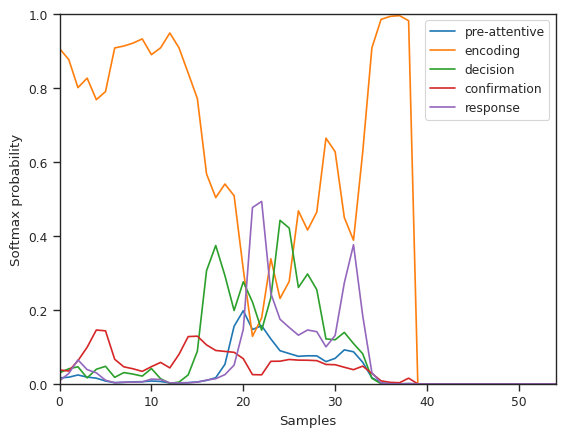

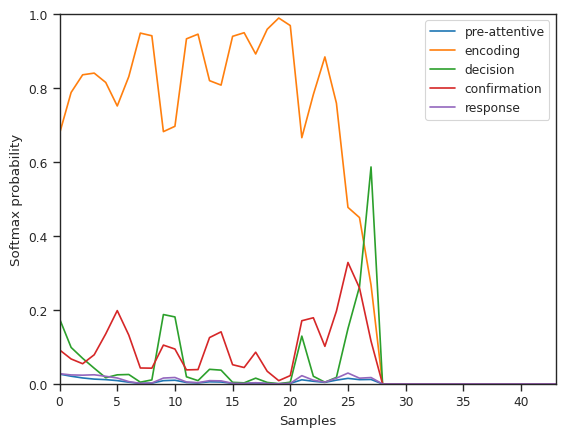

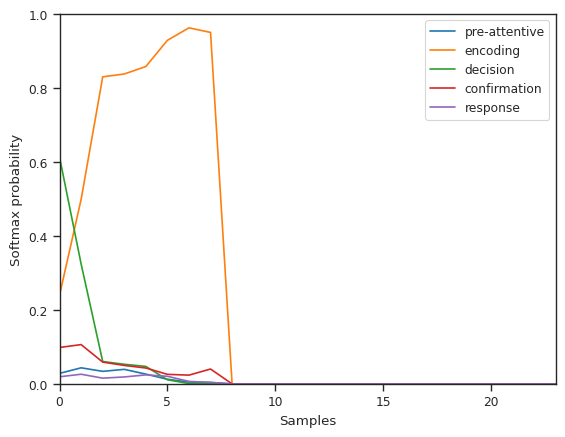

In [16]:
# In speed test set, get all decision labels and predict slices of it
torch.cuda.empty_cache()
torch.set_grad_enabled(False)
softmax = torch.nn.Softmax(dim=1)

cnt = 0
for item in test_dataset_sp: 
    data, label, info = item
    # Decision
    if label == 2:
        rt = info['rt']
        part = info['participant']
        epoch = info['epochs']
        plot_stage_predictions(data, SAT_CLASSES_ACCURACY, 11, model)
        # print(slices)
        # try:
        #     print(slices)
        # except Exception:
        #     print('Model couldn\'t predict')
    cnt += 1
    if cnt > 100:
        break

In [15]:
# In speed test set, get all true decision labels and predict them
torch.cuda.empty_cache()
torch.set_grad_enabled(False)
softmax = torch.nn.Softmax(dim=1)
pred_probas = []
rts = []
participants = []
epochs = []
cnt = 0
for item in test_dataset_sp:
    # 'rt' must be in info_to_keep
    data, label, info = item
    # Decision
    if label == 2:
        rt = info['rt']
        part = info['participant']
        epoch = info['epochs']
        try:
            pred = model(data.unsqueeze(0).to(DEVICE))
        except Exception:
            print('Oopsie')
        probas = softmax(pred)
        pred_probas.append(probas.squeeze())
        rts.append(rt)
        participants.append(part)
        epochs.append(epoch)
    cnt += 1
    if cnt > np.inf:
        break
probas = torch.stack(pred_probas)

Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie
Oopsie


In [16]:
behaviour_sat2 = read_behavioural_info(DATA_PATH / "sat2/behavioural/df_full.csv")

data = pd.DataFrame(probas.detach().cpu(), columns=SAT_CLASSES_ACCURACY)
data['rt'] = rts
data['participant'] = participants
data['epoch'] = epochs
data = data.merge(behaviour_sat2, left_on=["participant", "epoch"], right_on=["participant", "trial"])

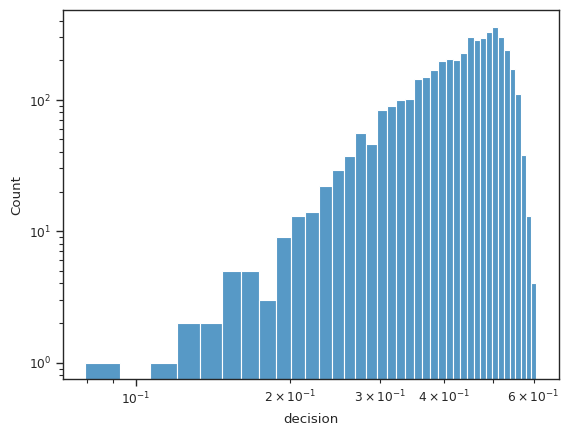

In [17]:
g = sns.histplot(data, x='decision')
g.set_yscale('log')
g.set_xscale('log')
# plt.xlim(0.8, 1.0)
plt.show()

In [40]:
q1 = data.decision.quantile(0.33)
q2 = data.decision.quantile(0.66)
print(q1, q2)
data['q'] = pd.cut(data['decision'], bins=[-np.inf, q1, q2, np.inf], labels=['first', 'second', 'third'])

0.9928511065244675 0.9982982349395751


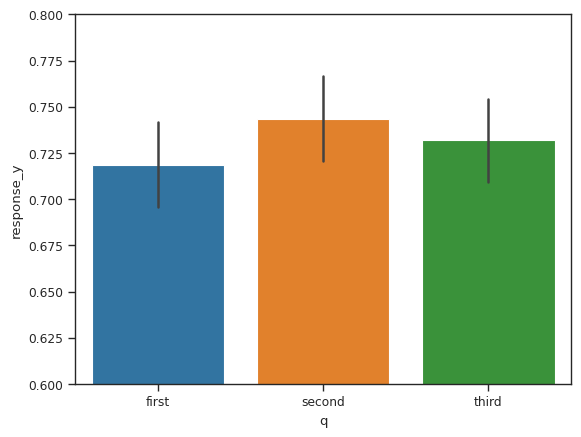

In [39]:
# Lower probability of decision should imply greater probability of it including confirmation activity
# But it doesnt? Lower probability of decision being classified as decision implies slightly worse performance
# Model could have just learned what decision operation starts with (given that we think most identifying information occurs around the transition event)
# And just predicts decision confidently
sns.barplot(data, x='q', y='response_y', hue='q')
plt.ylim(0.6,0.8)
plt.show()

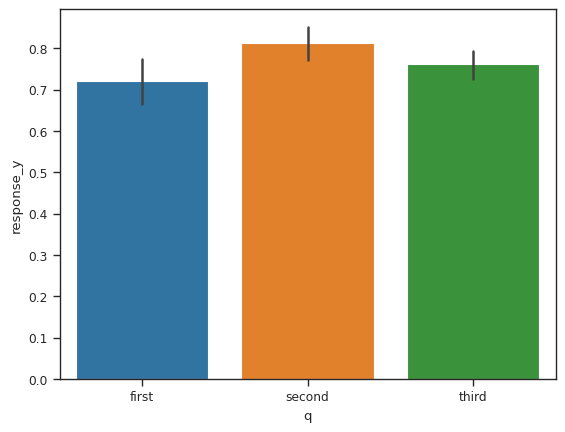

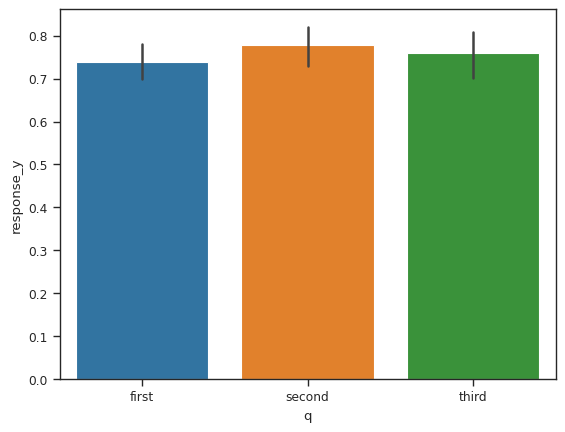

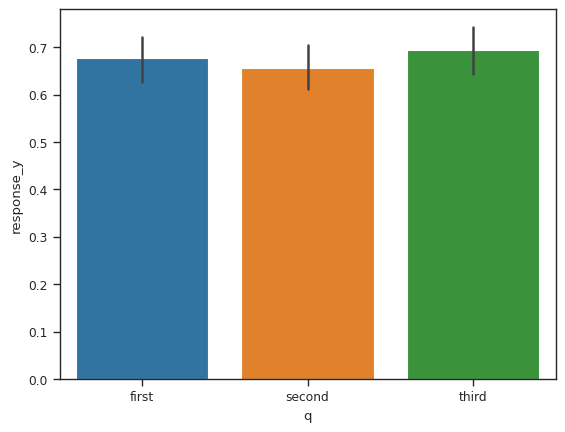

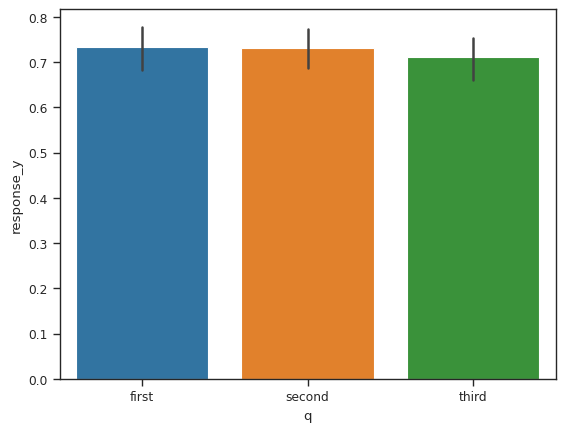

In [34]:
for participant in test_data.participant:
    sns.barplot(data[data.participant == participant], x='q', y='response_y', hue='q')
    plt.show()

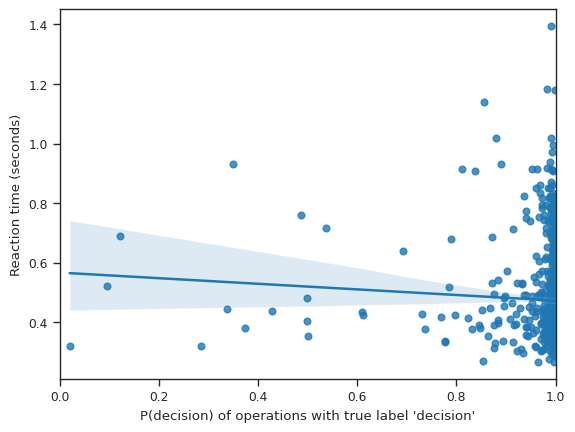

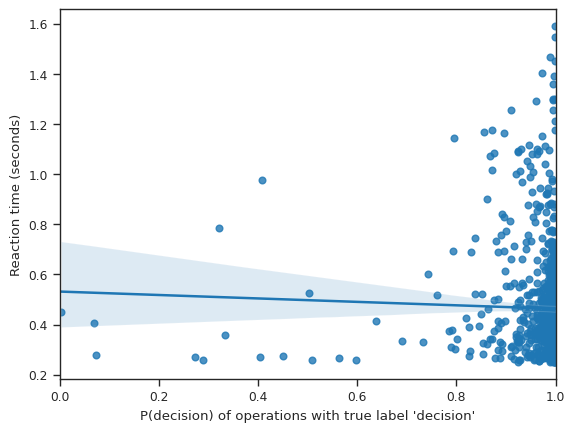

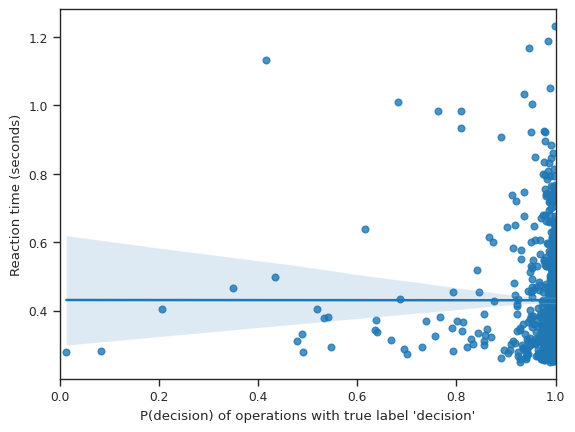

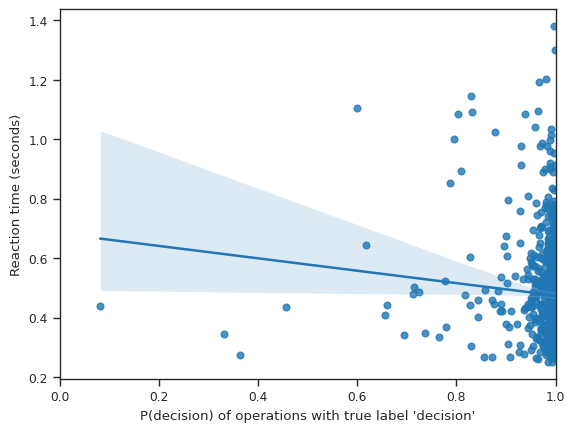

In [26]:
for participant in test_data.participant:
    sns.regplot(data[data.participant == participant], x='decision', y='rt_x')
    plt.xlim(0,1)
    plt.xlabel("P(decision) of operations with true label 'decision'")
    plt.ylabel("Reaction time (seconds)")
    plt.show()

<Axes: xlabel='decision', ylabel='rt_x'>

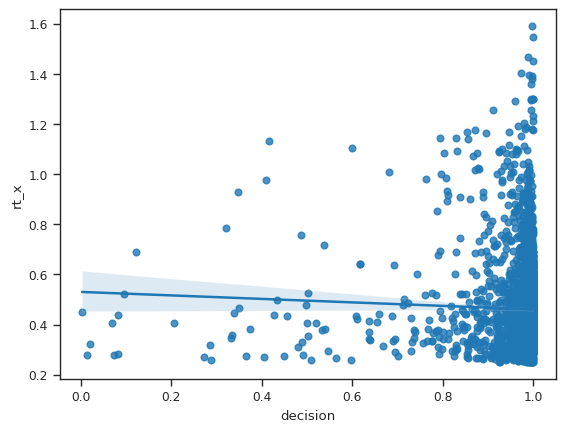

In [42]:
sns.regplot(data, x='decision', y='rt_x')

In [36]:
probas.mean(dim=0)
# Check if probability of confirmation (or being uncertain about decision) correlates with RT?
# Maybe check parts of longer stages to check if confirmation is predicted

tensor([0.0084, 0.0036, 0.9773, 0.0089, 0.0017], device='cuda:0')